In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(len(files), len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 50 # Only use 10 images for training

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


Image size = 400,400


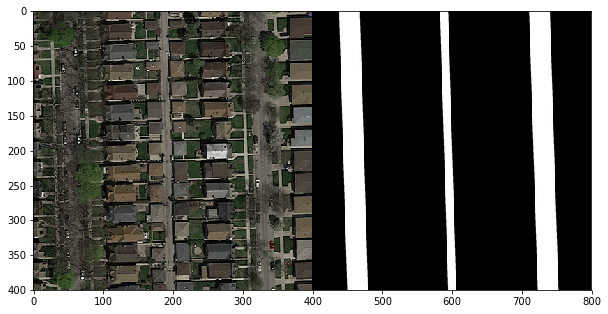

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

Image size = 400,400


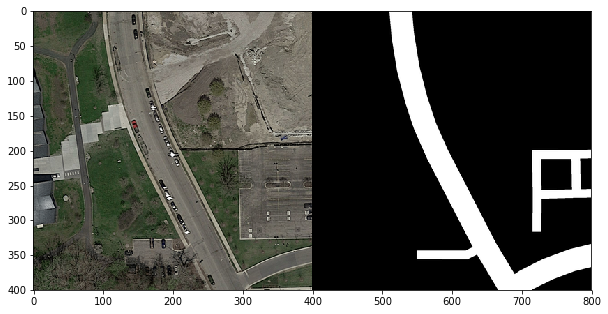

In [5]:
print('Image size = ' + str(imgs[43].shape[0]) + ',' + str(imgs[43].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[43], gt_imgs[43])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [6]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [7]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

In [8]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 0
    else:
        return 1

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [9]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 31250 features
Feature dimension = 2
Number of classes = 1
Class 0: 8081 samples
Class 1: 23169 samples


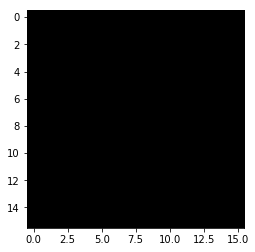

In [10]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

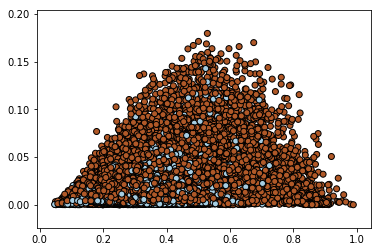

In [11]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [12]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [13]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.359552


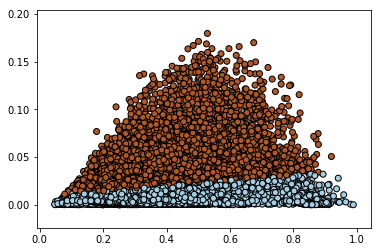

In [14]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [15]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

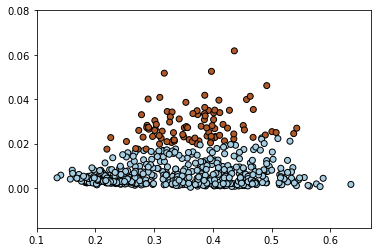

In [16]:
# Run prediction on the img_idx-th image
img_idx = 43

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

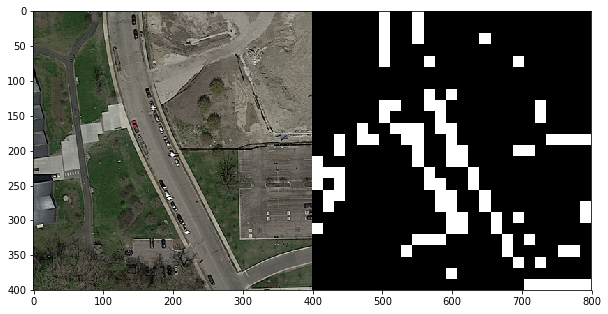

In [17]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

#new_img = make_img_overlay(imgs[img_idx], predicted_im)

#plt.imshow(new_img)

### Test LogisticReg with Pytorch

In [203]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(len(files), len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = load_image(image_dir + files[43])
print(files[43])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = load_image(gt_dir + files[43])
print(files[43])

Loading 100 images
satImage_032.png
Loading 100 images
satImage_032.png


Image size = 400,400


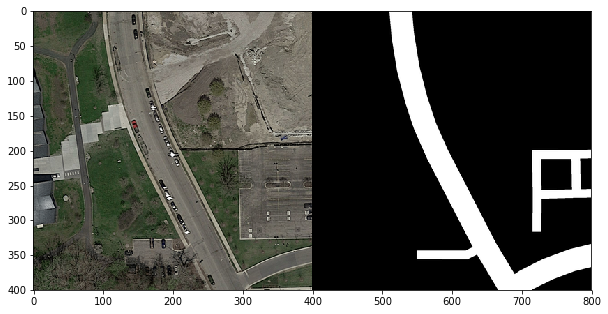

In [204]:
print('Image size = ' + str(imgs.shape[0]) + ',' + str(imgs.shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs, gt_imgs)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [232]:
# Extract patches from input images
patch_size = 1 # each patch is 16*16 pixels

img_patches = img_crop(imgs, patch_size, patch_size)
gt_patches = img_crop(gt_imgs, patch_size, patch_size)

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [233]:
X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [234]:
X.shape

(160000, 2)

In [235]:
def train(features, labels, model, lossfunc, optimizer, num_epoch):

    for epoch in range(num_epoch):
        # TODO: Step 1 - create torch variables corresponding to features and labels
        x = Variable(torch.from_numpy(features), requires_grad=False)
        y = Variable(torch.from_numpy(labels).type(torch.FloatTensor), requires_grad=False)

        # TODO: Step 2 - compute model predictions and loss
        y_preds = model(x)
        loss = lossfunc(y_preds, y)
        
        # TODO: Step 3 - do a backward pass and a gradient update step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epoch, loss.data[0]))

In [236]:
class NNLinearRegression(nn.Module):
    def __init__(self):
        super(NNLinearRegression, self).__init__()
        # TODO: Define the parameters of the model (linear nn layer)
        self.linear = torch.nn.Linear(2, 27, bias=False)
        self.sig = torch.nn.Sigmoid()
        self.linear2 = torch.nn.Linear(27, 1, bias=False)
    
    def forward(self, x):
        # TODO: implement forward computation
        return self.sig(self.linear2(self.sig(self.linear(x))))
    
# Training and visualizing predictions made by linear regression model (nn package)
# TODO: use loss function from nn package
lossfunc = torch.nn.MSELoss()

model = NNLinearRegression()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

train(features = X,
      labels = Y,
      model = model,
      lossfunc = lossfunc,
      optimizer = optimizer,
      num_epoch = 1000)

Epoch [1/1000], Loss: 0.2246
Epoch [101/1000], Loss: 0.1468
Epoch [201/1000], Loss: 0.1307
Epoch [301/1000], Loss: 0.1261
Epoch [401/1000], Loss: 0.1243
Epoch [501/1000], Loss: 0.1235
Epoch [601/1000], Loss: 0.1231
Epoch [701/1000], Loss: 0.1228
Epoch [801/1000], Loss: 0.1227
Epoch [901/1000], Loss: 0.1227


In [237]:
img_idx = 43

Xi = extract_img_features(image_dir + files[img_idx])

In [247]:
Zi = model(Variable(torch.from_numpy(X)))
print(np.mean(Zi.data.numpy()))
clean_preds = np.asarray([value_to_class(np.mean(Zi.data.numpy())) for i in range(len(Zi.data.numpy()))])
#plt.scatter(Xi[:, 0], Xi[:, 1], c=clean_preds, edgecolors='k', cmap=plt.cm.Paired)

0.848648


In [248]:
clean_preds

array([0, 0, 0, ..., 0, 0, 0])

/Users/Alexis/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


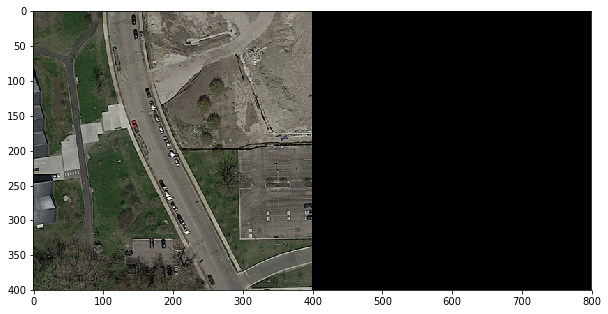

In [249]:
predicted_im = label_to_img(w, h, patch_size, patch_size, clean_preds)
cimg = concatenate_images(imgs, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

### Test to apply CNN

In [578]:
def train(model, loss, optimizer, x_val, y_val):
    x = Variable(x_val, requires_grad=False)
    y = Variable(y_val, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    output = loss.forward(fx, y)

    # Backward
    output.backward()

    # Update parameters
    optimizer.step()

    return output.data[0]


In [579]:
def predict(model, x_val):
    x = Variable(x_val, requires_grad=False)
    output = model.forward(x)
    return output.data.numpy().argmax(axis=1)

In [869]:
class ConvNet(torch.nn.Module):
    def __init__(self, output_dim):
        super(ConvNet, self).__init__()

        self.conv = torch.nn.Sequential()
        self.conv.add_module("conv_1", torch.nn.Conv2d(1, 10, kernel_size=1))
        self.conv.add_module("maxpool_1", torch.nn.MaxPool2d(kernel_size=1))
        self.conv.add_module("relu_1", torch.nn.ReLU())
        self.conv.add_module("conv_2", torch.nn.Conv2d(10, 20, kernel_size=1))
        self.conv.add_module("dropout_2", torch.nn.Dropout())
        self.conv.add_module("maxpool_2", torch.nn.MaxPool2d(kernel_size=1))
        self.conv.add_module("relu_2", torch.nn.ReLU())

        self.fc = torch.nn.Sequential()
        self.fc.add_module("fc1", torch.nn.Linear(40, 50))
        self.fc.add_module("relu_3", torch.nn.ReLU())
        self.fc.add_module("dropout_3", torch.nn.Dropout())
        self.fc.add_module("fc2", torch.nn.Linear(50, output_dim))
        
    def forward(self, x):
        x = self.conv.forward(x)
        x = x.view(-1, 40)
        return self.fc.forward(x)

In [870]:
X.shape

(31250, 2)

In [882]:
Xi.shape

(625, 2)

In [883]:
X_conv = X.reshape(-1, 1, 1, 2)
Xi_conv = Xi.reshape(-1, 1, 1, 2)

In [884]:
X_conv.shape

(31250, 1, 1, 2)

In [885]:
Xi_conv.shape

(625, 1, 1, 2)

In [886]:
n_examples = len(X_conv)
n_classes = 2
model = ConvNet(output_dim=n_classes)
loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
batch_size = 100

In [887]:
X_conv = torch.from_numpy(X_conv).float()
Xi_conv = torch.from_numpy(Xi_conv).float()
Y_conv = torch.from_numpy(Y).long()

In [888]:
Yi = extract_img_features(gt_dir + files[img_idx])

In [889]:
Yi.shape

(625, 2)

In [890]:
predY
for i in range(20):
    cost = 0.
    num_batches = n_examples // batch_size
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        cost += train(model, loss, optimizer, X_conv[start:end], Y_conv[start:end])
    predY = predict(model, Xi_conv)
    print("Epoch %d, cost = %f, acc = %.2f%%"
          % (i + 1, cost / num_batches, 100. * np.mean(predY == Yi)))

/Users/Alexis/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1, cost = 0.576728, acc = 0.00%
Epoch 2, cost = 0.571656, acc = 0.00%
Epoch 3, cost = 0.571336, acc = 0.00%
Epoch 4, cost = 0.571293, acc = 0.00%
Epoch 5, cost = 0.570919, acc = 0.00%
Epoch 6, cost = 0.570423, acc = 0.00%
Epoch 7, cost = 0.569836, acc = 0.00%
Epoch 8, cost = 0.568716, acc = 0.00%
Epoch 9, cost = 0.566953, acc = 0.00%
Epoch 10, cost = 0.564792, acc = 0.00%
Epoch 11, cost = 0.562159, acc = 0.00%
Epoch 12, cost = 0.561006, acc = 0.00%
Epoch 13, cost = 0.559513, acc = 0.00%
Epoch 14, cost = 0.559037, acc = 0.00%
Epoch 15, cost = 0.555407, acc = 0.00%
Epoch 16, cost = 0.555167, acc = 0.00%
Epoch 17, cost = 0.555862, acc = 0.00%
Epoch 18, cost = 0.553602, acc = 0.00%
Epoch 19, cost = 0.554446, acc = 0.00%
Epoch 20, cost = 0.552482, acc = 0.00%


In [891]:
predY

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,